<a href="https://colab.research.google.com/github/KaruDevs/PREDICCION-DE-NATALIDAD-SEGUN-FACTORES-SOCIOECONOMICOS/blob/main/ConsolidadoM8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resumen del dataset:
       PIB_per_capita  Acceso_Salud  Nivel_Educativo  Tasa_Empleo_Femenino  \
count      100.000000    100.000000       100.000000            100.000000   
mean     30859.940886     74.891586        12.764020             54.557447   
std      16361.917606     14.655563         4.401394             14.672611   
min       5303.716442     50.347607         5.075924             30.719674   
25%      15626.041838     62.100226         9.153198             42.480746   
50%      30527.835008     75.281243        13.438324             55.485915   
75%      45161.171556     88.309180        16.285504             66.788876   
max      59278.781513     99.282523        19.850808             79.525257   

       Edad_Maternidad  Urbanizacion  Tasa_Natalidad  
count       100.000000    100.000000      100.000000  
mean         27.740687     61.517985       32.547017  
std           4.779013     17.827325        7.379215  
min          20.162565     30.872680       13.057745  
2

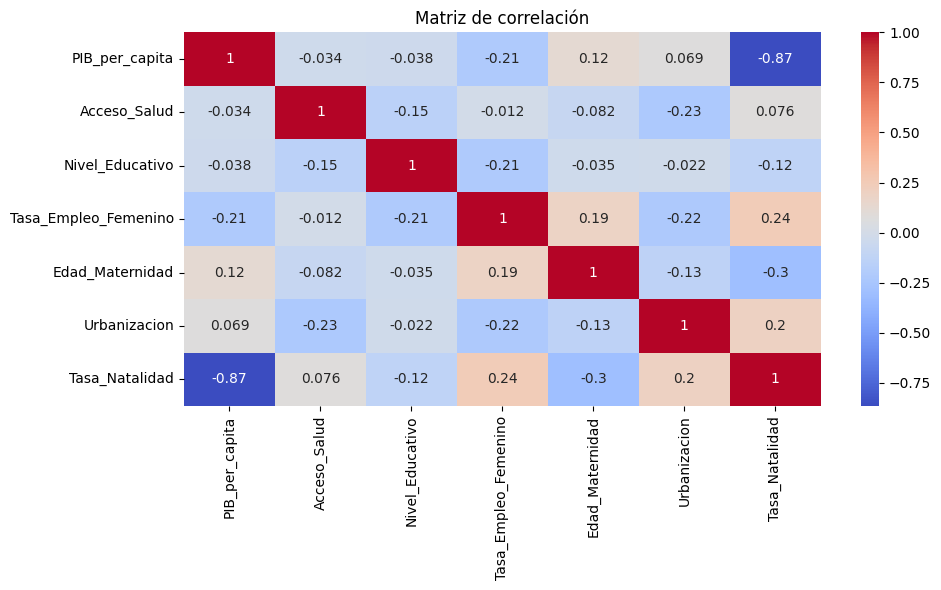

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
MAE: 5.18
RMSE: 5.86


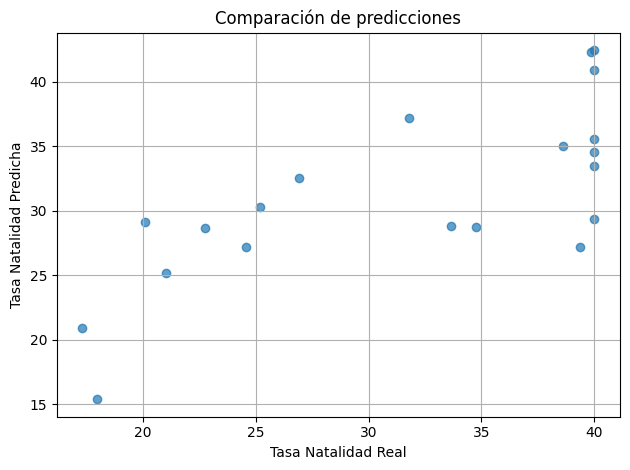

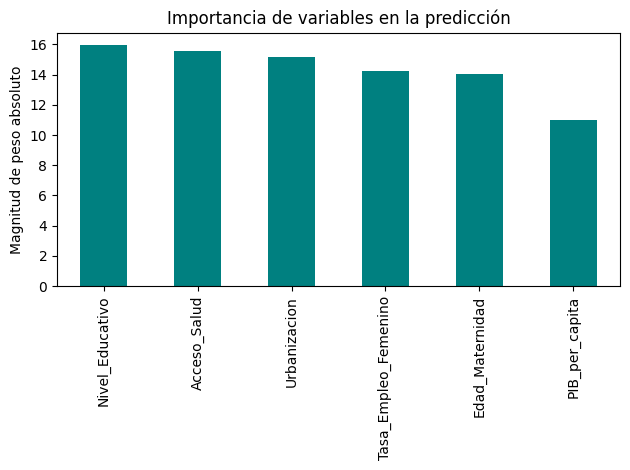


Variables más influyentes:
Nivel_Educativo    15.970060
Acceso_Salud       15.587256
Urbanizacion       15.154737
dtype: float32


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# 1️ Carga y exploración de datos
def cargar_y_explorar(ruta):
    df = pd.read_csv(ruta)
    print("Resumen del dataset:")
    print(df.describe())

    # Eliminamos columna no numérica antes de calcular la correlación
    df_numeric = df.drop(columns=["País"])

    print("\nCorrelaciones:")
    print(df_numeric.corr())

    # Visualización de correlaciones
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
    plt.title("Matriz de correlación")
    plt.tight_layout()
    plt.show()

    return df

# 2️ Preparación de datos
def preparar_datos(df):
    df = df.drop(columns=["País"])  # Eliminamos columna no numérica
    X = df.drop(columns=["Tasa_Natalidad"])
    y = df["Tasa_Natalidad"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, X.columns

# 3️ Construcción del modelo
def construir_modelo(input_dim, activacion='relu', dropout_rate=0.3, l2_rate=0.01):
    model = Sequential([
        Dense(64, activation=activacion, input_dim=input_dim, kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(32, activation=activacion, kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(1, activation='linear')  # Regresión
    ])
    return model

# 4️ Entrenamiento del modelo
def entrenar_modelo(model, X_train, y_train, lr=0.001, epochs=150):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mean_squared_error',
                  metrics=['mae'])
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, verbose=0)
    return history

# 5️ Evaluación del modelo
def evaluar_modelo(model, X_test, y_test):
    predicciones = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, predicciones)
    rmse = np.sqrt(mean_squared_error(y_test, predicciones))
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    plt.scatter(y_test, predicciones, alpha=0.7)
    plt.xlabel("Tasa Natalidad Real")
    plt.ylabel("Tasa Natalidad Predicha")
    plt.title("Comparación de predicciones")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return predicciones

# 6️ Análisis de importancia de variables
def importancia_variables(model, columnas):
    pesos = model.layers[0].get_weights()[0]
    importancia = np.sum(np.abs(pesos), axis=1)
    importancia_df = pd.Series(importancia, index=columnas).sort_values(ascending=False)

    importancia_df.plot(kind='bar', color='teal')
    plt.title("Importancia de variables en la predicción")
    plt.ylabel("Magnitud de peso absoluto")
    plt.tight_layout()
    plt.show()

    return importancia_df

# 🔁 Ejecución principal
if __name__ == "__main__":
    ruta = "dataset_natalidad.csv"
    df = cargar_y_explorar(ruta)
    X_train, X_test, y_train, y_test, columnas = preparar_datos(df)
    modelo = construir_modelo(input_dim=X_train.shape[1])
    historia = entrenar_modelo(modelo, X_train, y_train)
    predicciones = evaluar_modelo(modelo, X_test, y_test)
    importancia = importancia_variables(modelo, columnas)

    # Guardar reflexiones clave
    print("\nVariables más influyentes:")
    print(importancia.head(3))